In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # Speeds up training on RTX 4070
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Read the label mapping for artists
artist_index = {}
with open("artist_class.txt", "r") as f:
    for line in f:
        index, label = line.strip().split()
        artist_index[label] = int(index)

# Print the mapping
print("Label Mapping:", artist_index)  

artist_test_csv = pd.read_csv('artist_train.csv')
artist_valid_csv = pd.read_csv('artist_val.csv')

Label Mapping: {'Albrecht_Durer': 0, 'Boris_Kustodiev': 1, 'Camille_Pissarro': 2, 'Childe_Hassam': 3, 'Claude_Monet': 4, 'Edgar_Degas': 5, 'Eugene_Boudin': 6, 'Gustave_Dore': 7, 'Ilya_Repin': 8, 'Ivan_Aivazovsky': 9, 'Ivan_Shishkin': 10, 'John_Singer_Sargent': 11, 'Marc_Chagall': 12, 'Martiros_Saryan': 13, 'Nicholas_Roerich': 14, 'Pablo_Picasso': 15, 'Paul_Cezanne': 16, 'Pierre_Auguste_Renoir': 17, 'Pyotr_Konchalovsky': 18, 'Raphael_Kirchner': 19, 'Rembrandt': 20, 'Salvador_Dali': 21, 'Vincent_van_Gogh': 22}


In [12]:
# Read the label mapping for genre
genre_index = {}
with open("genre_class.txt", "r") as f:
    for line in f:
        index, label = line.strip().split()
        genre_index[label] = int(index)

# Print the mapping
print("Label Mapping:", genre_index)  

Label Mapping: {'abstract_painting': 0, 'cityscape': 1, 'genre_painting': 2, 'illustration': 3, 'landscape': 4, 'nude_painting': 5, 'portrait': 6, 'religious_painting': 7, 'sketch_and_study': 8, 'still_life': 9}


In [13]:
# Read the label mapping for genre
style_index = {}
with open("style_class.txt", "r") as f:
    for line in f:
        index, label = line.strip().split()
        style_index[label] = int(index)

# Print the mapping
print("Label Mapping:", style_index)  

Label Mapping: {'Abstract_Expressionism': 0, 'Action_painting': 1, 'Analytical_Cubism': 2, 'Art_Nouveau': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Contemporary_Realism': 6, 'Cubism': 7, 'Early_Renaissance': 8, 'Expressionism': 9, 'Fauvism': 10, 'High_Renaissance': 11, 'Impressionism': 12, 'Mannerism_Late_Renaissance': 13, 'Minimalism': 14, 'Naive_Art_Primitivism': 15, 'New_Realism': 16, 'Northern_Renaissance': 17, 'Pointillism': 18, 'Pop_Art': 19, 'Post_Impressionism': 20, 'Realism': 21, 'Rococo': 22, 'Romanticism': 23, 'Symbolism': 24, 'Synthetic_Cubism': 25, 'Ukiyo_e': 26}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch Image Shape: torch.Size([32, 3, 224, 224])
Batch Label Shape: torch.Size([32])
Label: tensor([22,  4, 14,  1, 14,  1, 22, 10,  0, 17, 18,  6,  1,  1, 16, 22, 19, 14,
        22, 20,  8,  2, 17,  5, 11, 21, 14, 14,  5, 18, 12, 14])


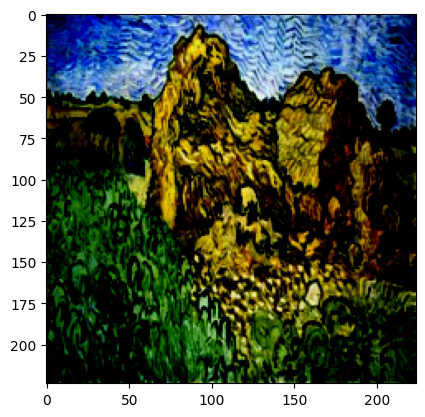

In [15]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Resize(224),  # Resize the smaller edge to 224 pixels
    #transforms.CenterCrop(224), # Crop the center
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset and dataloader
artist_train_dataset = ImageDataset(artist_test_csv, transform=transform)
artist_train_loader = DataLoader(artist_train_dataset, batch_size=32, shuffle=True)

artist_valid_dataset = ImageDataset(artist_valid_csv, transform=transform)
artist_valid_loader = DataLoader(artist_valid_dataset, batch_size=32, shuffle=True)

# Test DataLoader
sample_image, sample_label = next(iter(artist_train_loader))
print("Batch Image Shape:", sample_image.shape)  # (Batch, C, H, W)
print("Batch Label Shape:", sample_label.shape)  # (Batch,)
plt.imshow(sample_image[0].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
print(f"Label: {sample_label}")

In [23]:
import torch
import torch.nn as nn

class CustomCNN_GRU(nn.Module):
    def __init__(self, num_classes=23, hidden_size=256, num_layers=1):
        super(CustomCNN_GRU, self).__init__()

        # CNN Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Output: (batch, 512, 4, 4)
        )

        # GRU Layer (Processes CNN Features Sequentially)
        self.gru = nn.GRU(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully Connected Layers for Classification
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # CNN feature extraction
        x = x.view(x.size(0), 4, 512)  # Reshape to (batch, seq_len=4, features=512)
        
        _, hidden = self.gru(x)  # GRU processing (hidden shape: [num_layers, batch, hidden_size])
        x = hidden[-1]  # Use the last hidden state (batch, hidden_size)

        x = self.fc_layers(x)  # Classification
        return x  # No softmax (CrossEntropyLoss handles it)

In [6]:
# Hyperparameters 
torch.manual_seed(3)
model = CustomCNN_GRU()

In [24]:
import time
start_time = time.time()

#Create Variables to track things
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer & Loss Function
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping
best_val_loss = float('inf')
patience = 7
counter = 0

for epoch in range(50):  
    model.train()
    train_loss = 0
    for images, labels in artist_train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(artist_train_loader)  # Normalize

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in artist_valid_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(artist_valid_loader)  # Normalize

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Check Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  
    else:
        counter += 1  
        if counter >= patience:
            print("Early stopping triggered.")
            break  

    # Reduce Learning Rate if needed
    scheduler.step(val_loss) 
current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes!')

Epoch 1 | Train Loss: 1.8424 | Val Loss: 1.8079
Epoch 2 | Train Loss: 1.7614 | Val Loss: 1.7581
Epoch 3 | Train Loss: 1.7040 | Val Loss: 1.7182
Epoch 4 | Train Loss: 1.6561 | Val Loss: 1.6954
Epoch 5 | Train Loss: 1.6144 | Val Loss: 1.6666
Epoch 6 | Train Loss: 1.5885 | Val Loss: 1.6438
Epoch 7 | Train Loss: 1.5376 | Val Loss: 1.6327
Epoch 8 | Train Loss: 1.5084 | Val Loss: 1.6104
Epoch 9 | Train Loss: 1.4728 | Val Loss: 1.5985
Epoch 10 | Train Loss: 1.4388 | Val Loss: 1.5878
Epoch 11 | Train Loss: 1.4006 | Val Loss: 1.5720
Epoch 12 | Train Loss: 1.3660 | Val Loss: 1.5599
Epoch 13 | Train Loss: 1.3293 | Val Loss: 1.5432
Epoch 14 | Train Loss: 1.2913 | Val Loss: 1.5425
Epoch 15 | Train Loss: 1.2480 | Val Loss: 1.5414
Epoch 16 | Train Loss: 1.2158 | Val Loss: 1.5381
Epoch 17 | Train Loss: 1.1789 | Val Loss: 1.5386
Epoch 18 | Train Loss: 1.1419 | Val Loss: 1.5411
Epoch 19 | Train Loss: 1.1011 | Val Loss: 1.5418
Epoch 20 | Train Loss: 1.0619 | Val Loss: 1.5443
Epoch 21 | Train Loss: 1.0198

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in artist_valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 57.02%


In [30]:
checkpoint = {
    'epoch': 34,  # Current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),  # Save LR scheduler state
    'loss': best_val_loss
}

torch.save(checkpoint, 'model_checkpoint.pth')
print("Checkpoint saved successfully!")

Checkpoint saved successfully!


In [76]:
#Outliers Low confidence threshold
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
threshold=0.5  
model.eval()
outliers = []
    
with torch.no_grad():
    for images, labels in artist_train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)  # Get softmax probabilities
        max_probs, preds = torch.max(probs, dim=1)  # Get max prob for each sample

        # Flag samples where max probability is below threshold
        for i, prob in enumerate(max_probs):
            if prob < threshold:
                outliers.append(images[i])
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


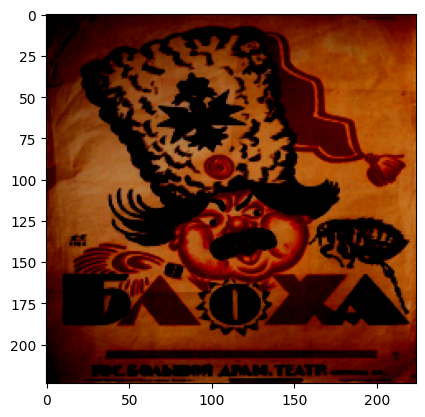

In [84]:
outliers = [t.cpu() for t in outliers]
plt.imshow(outliers[0].permute(1, 2, 0))